In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn
import math
seaborn.set(color_codes=True)

In [1]:
def gaussian_funiction_single(x, mu=0 ,sigma=1):
    return math.exp(-1*(x-mu)*(x-mu)/2/sigma/sigma)/sigma/math.sqrt(2*math.pi)
        
def gaussian_funiction(x, mu=0 ,sigma=1):
    if type(x) == list:
        x = np.array(x)
    if type(x).__module__==np.__name__:
        a = np.zeros(len(x))
        for i in range(len(x)):
            a[i] = gaussian_funiction_single(x[i],mu,sigma)
        return a
    else :
        return gaussian_funiction_single(x, mu, sigma)

In [3]:
class DataDistribution(object):
    '''
        The distribution of real data
    '''
    def __init__(self, mu = 2, sigma = 0.5):
        self.mu = mu
        self.sigma = sigma
        
    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort() #sort the elements in samples
        return samples

class GeneratorDistribution(object):
    '''
        The distribution of z
    '''
    def __init__(self, range_):
        self.range = range_

    def sample(self, N):
        samples = np.random.uniform(low = -self.range, high = self.range, size= N)
        samples.sort()
        return samples

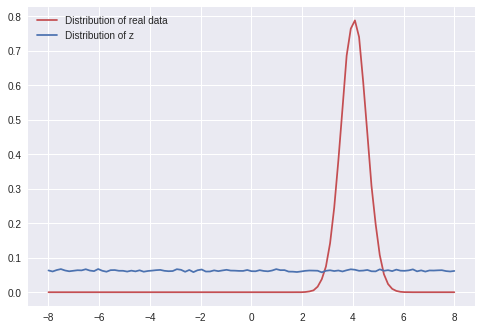

In [4]:
bins = np.linspace(-8, 8, 100)
d = DataDistribution(4, 0.5).sample(100000)
pd, _ = np.histogram(d, bins=bins, density=True)
g = GeneratorDistribution(8).sample(100000)
pg, _ = np.histogram(g, bins=bins, density=True)
p_x = np.linspace(-8, 8, len(pd))
plt.plot(p_x, pd, 'r-', label = 'Distribution of real data')
plt.plot(p_x, pg, 'b-', label = 'Distribution of z')
plt.legend()
plt.show()

In [5]:
def clip(x, vmin = 1e-7, vmax = 1.- 1e-7):
    return tf.clip_by_value(x, clip_value_min=vmin, clip_value_max=vmax)

def linear(x, output_dim, scope=None, stddev=1.0):
    XAVIER = tf.contrib.layers.xavier_initializer()
    CONST = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [x.get_shape()[1], output_dim], initializer=XAVIER)
        b = tf.get_variable('b', [output_dim], initializer=CONST)
        return tf.matmul(x, w) + b

def lrelu(x, leak=0.2):
    '''
        a kind of leaky relu

        input : 
            x - some kind of tensor or array or number
            leak - float
        return :
            x > 0 => x
            x < 0 => 0.5*(1+leak)x + 0.5*(leak-1)x = leak*x
    '''
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * tf.abs(x)

def generator(x):
    h0 = lrelu(linear(x, 10, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

def discriminator(x):
    h0 = lrelu(linear(x, 20, 'd0'))
    h1 = lrelu(linear(h0, 20, 'd1'))
    h2 = tf.nn.sigmoid(linear(h1, 1, scope='d2'))
    return h2

def optimizer(loss, var_list, initial_learning_rate):
    learning_rate = tf.Variable(initial_learning_rate, trainable= False)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
        loss,
        var_list = var_list
    )
    return learning_rate, optimizer

def change_var(sess, x, discount):
    new_var = sess.run(x)*discount
    sess.run(tf.assign(x, new_var))

In [6]:
class GAN(object):
    def __init__(self, data, gen, batch_size):
        self.data = data
        self.gen = gen
        self.batch_size = batch_size
        self.learning_rate = 0.01
        
        self._create_model()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def _create_model(self):        
        with tf.variable_scope('Gen'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z)

        with tf.variable_scope('Disc') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))          
            self.D1 = discriminator(self.x)
            scope.reuse_variables()
            self.D2 = discriminator(self.G)

        self.loss_d = tf.reduce_mean(-tf.log(clip(self.D1)) - tf.log(clip(1 - self.D2)))
        self.loss_g = tf.reduce_mean(-tf.log(clip(self.D2)))

        self.d_params = tf.get_collection("trainable_variables", scope='Disc')
        self.g_params = tf.get_collection("trainable_variables", scope='Gen')

        self.d_lr, self.opt_d = optimizer(self.loss_d, self.d_params, self.learning_rate)
        self.g_lr, self.opt_g = optimizer(self.loss_g, self.g_params, self.learning_rate)
    
    def train(self, nsteps, log_every):
        for step in range(nsteps):
            # update discriminator
            x = self.data.sample(self.batch_size) # sample from original data
            z = self.gen.sample(self.batch_size) # sample from random
            loss_d, _ = self.sess.run([self.loss_d, self.opt_d], {
                self.x : np.reshape(x, (self.batch_size, 1)),
                self.z : np.reshape(z, (self.batch_size, 1))
            })

            # update generator
            z = self.gen.sample(self.batch_size)
            loss_g, _ = self.sess.run([self.loss_g, self.opt_g], {
                self.z: np.reshape(z, (self.batch_size, 1))
            })

            if step % log_every == (log_every-1):
                print('{}: \t discriminator error{}\t generatore error{}'.format(step+1, loss_d, loss_g))
                change_var(self.sess, self.d_lr, 0.7)
                change_var(self.sess, self.g_lr, 0.7)
                self._plot_distributions()
            
    def _samples(self, num_points=10000, num_bins=50):
        '''
            pd : a histogram of samples from the data distribution,
            pg : a histogram of generated samples.
        '''
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # data distribution
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # generated samples
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = self.sess.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return pd, pg

    def _plot_distributions(self):
        pd, pg = self._samples()
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        f, ax = plt.subplots(1)
        ax.set_ylim(0, 1)
        plt.plot(p_x, pd, 'r-',label='real data')
        plt.plot(p_x, pg, 'g-',label='generated data')
        plt.title('1D Generative Adversarial Network')
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()

In [7]:
model = GAN(
    data = DataDistribution(mu = 4, sigma = 0.5),#data
    gen = GeneratorDistribution(8), #gen
    batch_size = 100
)

1000: 	 discriminator error1.411545991897583	 generatore error0.738340437412262


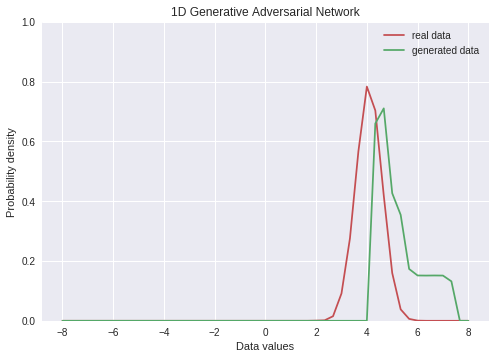

2000: 	 discriminator error1.40688157081604	 generatore error0.5745847821235657


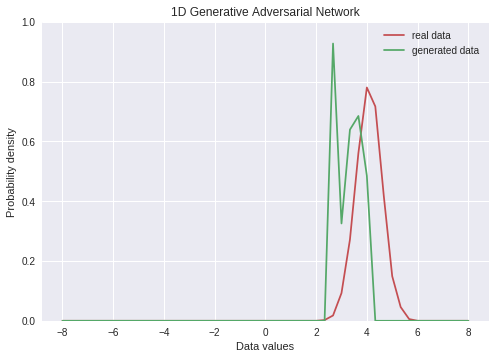

3000: 	 discriminator error1.3494755029678345	 generatore error0.6371196508407593


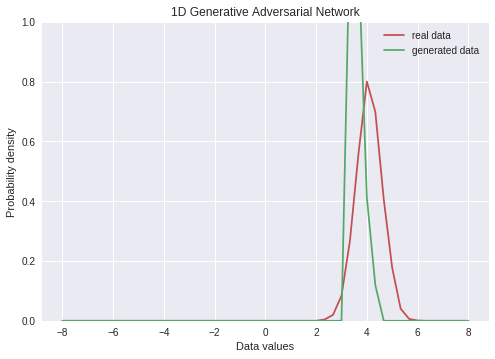

4000: 	 discriminator error1.3641374111175537	 generatore error0.7448430061340332


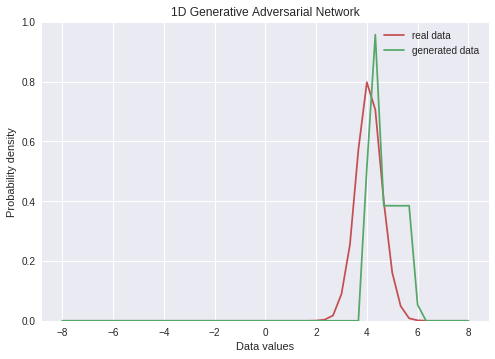

5000: 	 discriminator error1.3987526893615723	 generatore error0.755598247051239


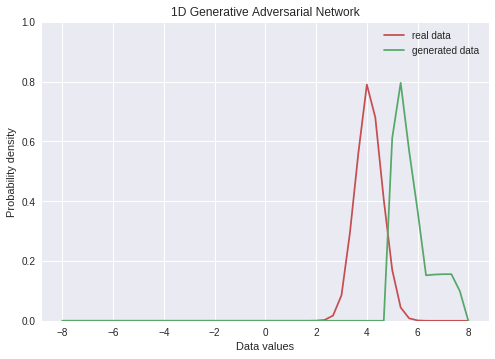

6000: 	 discriminator error1.3642988204956055	 generatore error0.7672082781791687


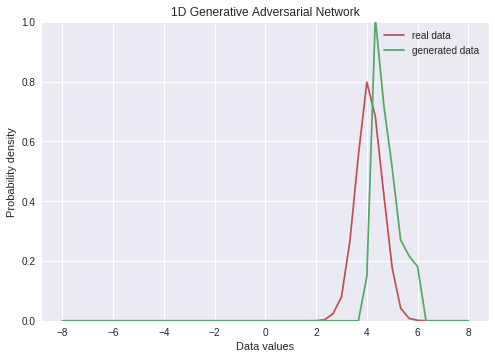

7000: 	 discriminator error1.3534724712371826	 generatore error0.6544069647789001


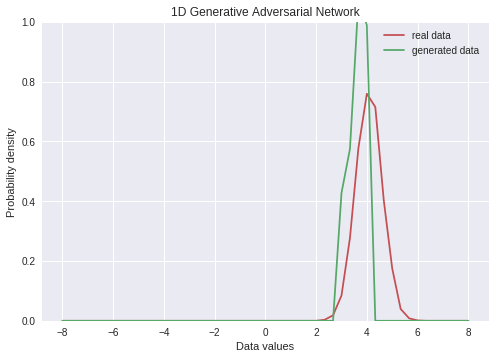

8000: 	 discriminator error1.3849014043807983	 generatore error0.7062402367591858


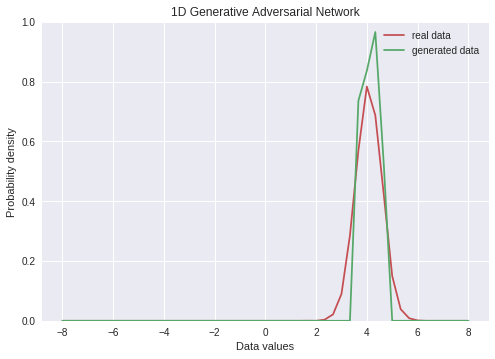

9000: 	 discriminator error1.3928000926971436	 generatore error0.7122242450714111


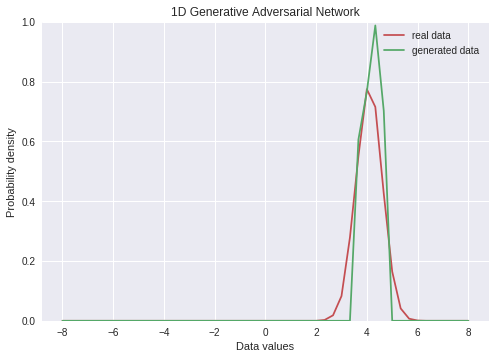

10000: 	 discriminator error1.3856027126312256	 generatore error0.7203052043914795


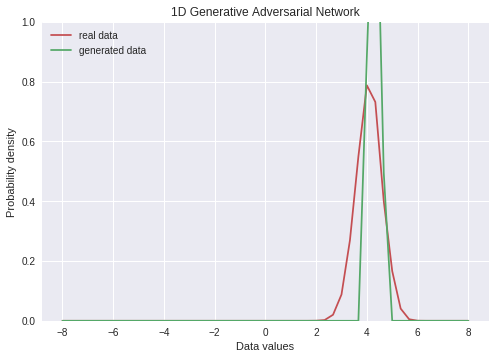

In [8]:
model.train(nsteps=10000, log_every=1000)